# Feed Forward NN with Backpropagation

Assignment info: You can try to **implement a two-layer neural network using just basic Python and numpy** (so no torch, TensorFlow, Jax, etc.) from scratch. The network takes as **input a vector of size 64 and outputs a vector of size 2**. The first hidden unit has **32 neurons and a ReLU activation, while the output has a softmax activation**. The loss function is the categorical cross-entropy.What really matters here is that you try to code the backpropagation phase manually. That helps a lot in understanding how neural networks work!

In [7]:
# libraries
import numpy as np
import math

## Making Smiling and Frowning Faces to Classify

In [3]:
# make and show data
# I will be trying to classifly 8 by 8 grayscale images of smiling or frowning faces

# smiling face
smiling_base = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1, 0],
    [0, 0, 1, 1, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
])

# frowning face
frowning_base = np.array([
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 1, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 0],
    [0, 0, 1, 1, 1, 1, 0, 0],
    [0, 1, 0, 0, 0, 0, 1, 0],
    [0, 1, 0, 0, 0, 0, 1, 0],
])

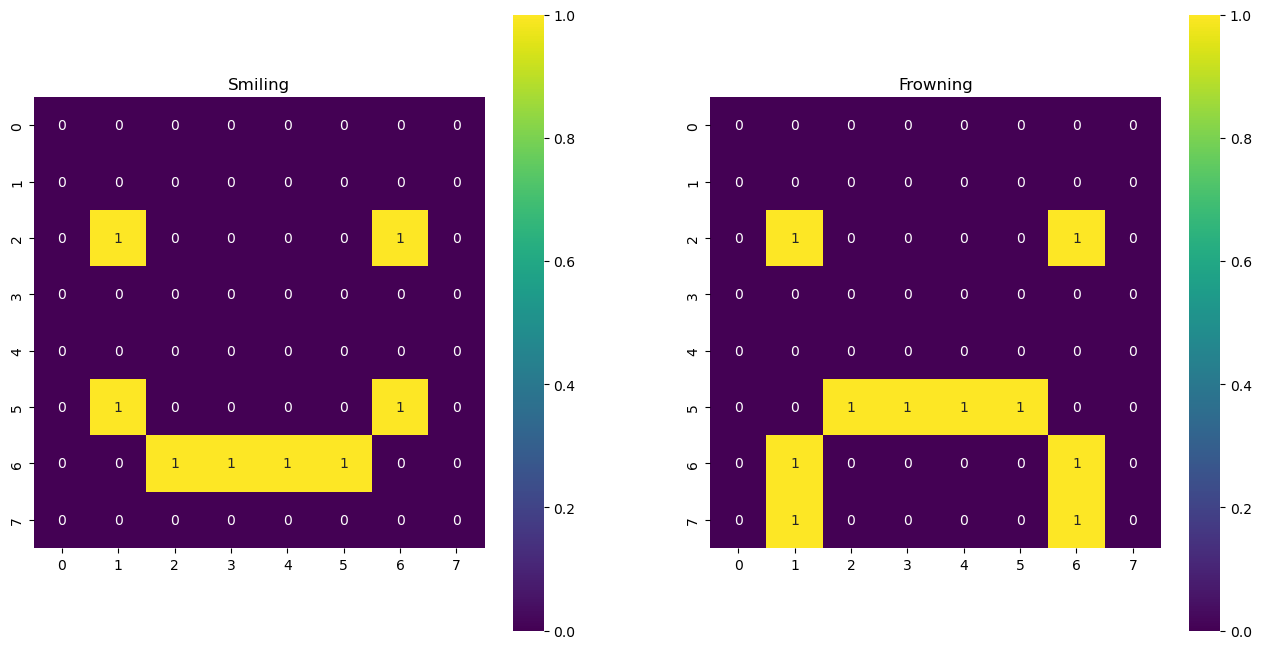

In [4]:
# visualize the two faces
import seaborn as sns
import matplotlib.pyplot as plt

def show2(a1, a2):
    # Create the heatmap
    fig, axes = plt.subplots(1, 2, figsize=(16,8))
    sns.heatmap(a1, annot=True, cmap="viridis", square=True, ax=axes[0])
    axes[0].set_title("Smiling")
    sns.heatmap(a2, annot=True, cmap="viridis", square=True, ax=axes[1])
    axes[1].set_title("Frowning")

show2(smiling_base, frowning_base)

# Display the plot
# plt.tight_layout()
# plt.show()

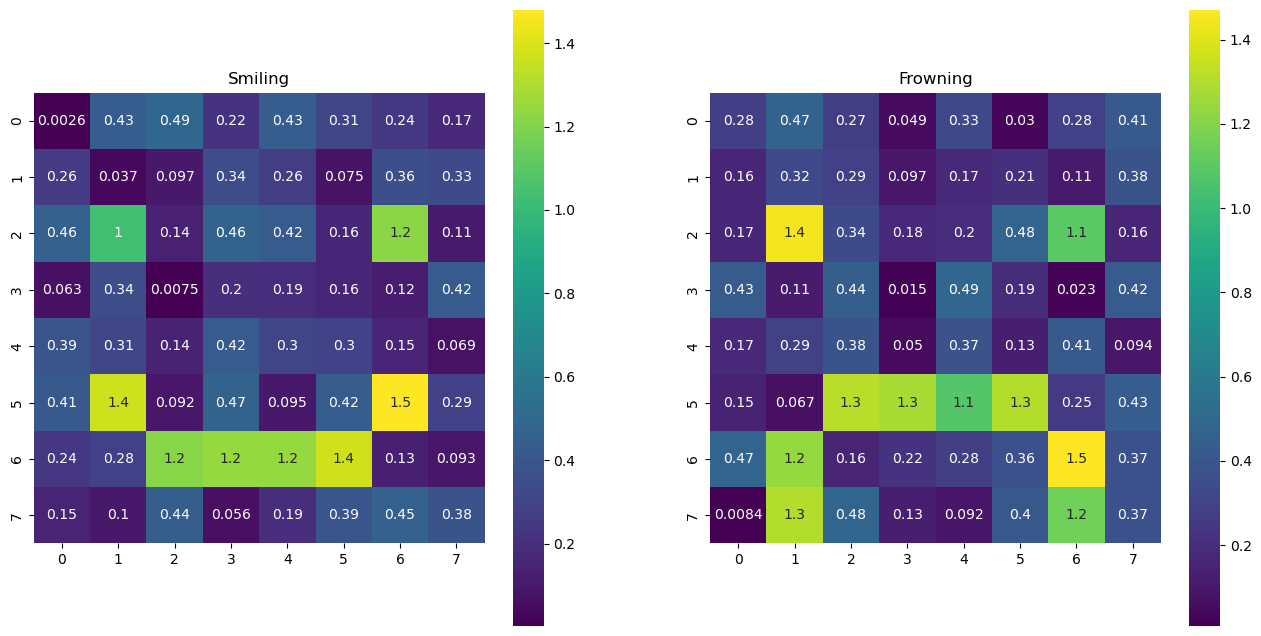

In [5]:
# create training data by adding noise to the bases
DATA_SIZE = 200

training_smiles = np.random.rand(DATA_SIZE, 8, 8) * 0.5 + smiling_base
training_frowns = np.random.rand(DATA_SIZE, 8, 8) * 0.5 + frowning_base

show2(training_smiles[0], training_frowns[0])


## Now For Classification

### Plan
I'm going to make a class for layers of the network, then put them together to make the full model.

In [9]:
# define a class for a layer
# layer.forward can take input and return output using its weights, biases, and activation function
# layer.backward should take the error and adjust the parameters

class Layer:
    def __init__(self, input_size, output_size, activation_function):
        self.input_size = input_size
        self.output_size = output_size
        self.activation_function = activation_function
        self.weights = np.random.uniform(low=-1, high=1, size=(input_size, output_size))
        self.biases = np.random.uniform(low=-1, high=1, size=(output_size,))
        self.grad_weights = np.zeros(input_size * output_size)
        self.grad_biases = np.zeros(output_size)
        self.grad_inputs = np.zeros(input_size)
        self.node_out_values_for_sgd = np.zeros(output_size)
        self.node_in_values_for_sgd = np.zeros(input_size)
    
    def forward(self, x):
        # return self.activation_function(np.dot(x, self.weights) + self.biases)
        weighted_sum = np.dot(x, self.weights)
        with_bias = weighted_sum + self.biases
        with_activation = self.activation_function(with_bias)

        # save the node values; they will be useful in calculating the gradient later
        self.node_out_values_for_sgd = with_activation
        self.node_in_values_for_sgd = x

        return with_activation
    
    def backward(self, loss):
        # gradient of weight = x * gradient of node before (derivative w.r.t loss)
        # keep the dimensions in mind, test constantly
        self.grad_weights = self.node_in_values_for_sgd * self.activation_derivative(loss)
        self.grad_biases = 1 * self.activation_derivative(loss)
        self.grad_inputs = self.weights * self.activation_derivative(loss)

        # pass the gradient of this layer's inputs to the previous layer
        return self.grad_inputs
        
    def step(self, learning_rate):
        pass

class TwoLayers:
    def __init__(self, l1, l2):
        self.l1 = l1
        self.l2 = l2
        self.final_loss = np.zeros(2)
    
    def forward(self, x):
        intermediate = self.l1.forward(x)
        final = self.l2.forward(intermediate)

        # normalize the final sigmoid outputs so they both add to 1
        total = np.sum(final)
        return final / total

    def loss(self, predicted, actual):
        # categorical cross-entropy
        # Formula:-Σ(y_i * log(p_i)) Where y_i is the true probability of class i, and p_i is the predicted probability. And log is ln (natural log)
        
        lossarray = -1.0 * np.log(predicted) * actual

        # store each final node's contribution to the loss for backpropagation later
        self.final_loss = lossarray

        total_loss = np.sum(lossarray)
        return total_loss
    
    def backward(self):
        # flow the signal back through the network
        intermediate_loss = self.l2.backward(self.final_loss)
        self.l1.backward(intermediate_loss)

    def step(self, learning_rate):
        self.l2.step(learning_rate)
        self.l1.step(learning_rate)


## Activation Functions

Text(0.5, 1.0, 'Sigmoid')

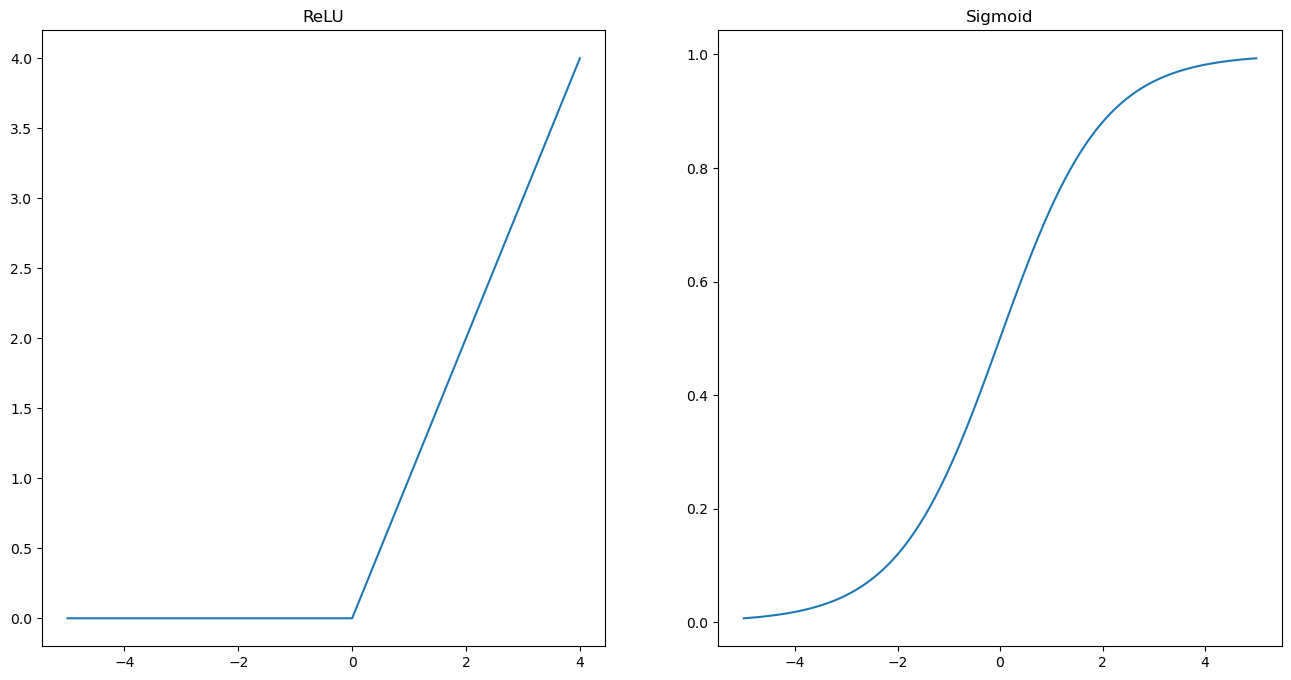

In [56]:
# activation functions
# vectorize so I can apply the functions elementwise to numpy arrays
relu = np.vectorize(lambda x : x if x > 0 else 0)

xs = np.arange(-5,5,1)
ys = relu(xs)

sigmoid = np.vectorize(lambda x: 1.0 / (1.0 + math.exp(-x)))

fig, axes = plt.subplots(1, 2, figsize=(16,8))
axes[0].plot(xs,ys)
axes[0].set_title("ReLU")

xs = np.linspace(-5,5,100)
ys = sigmoid(xs)

axes[1].plot(xs, ys)
axes[1].set_title("Sigmoid")

In [44]:
# try a forward pass
l1 = Layer(64, 2, np.vectorize(relu))
l1.forward(np.ones(64))

array([28.62222008, 31.3055528 ])

## Training

## Detection